### Let's do a regression example!
 
 Let's predict fuel efficiency

In [1]:
#The imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
#Let's download the data!
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)


In [15]:
dataset = raw_dataset.copy()
dataset = dataset.dropna()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [16]:
#Let's convert origin to numeric value
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})


In [17]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [18]:
#let's split the data into training and testing!
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

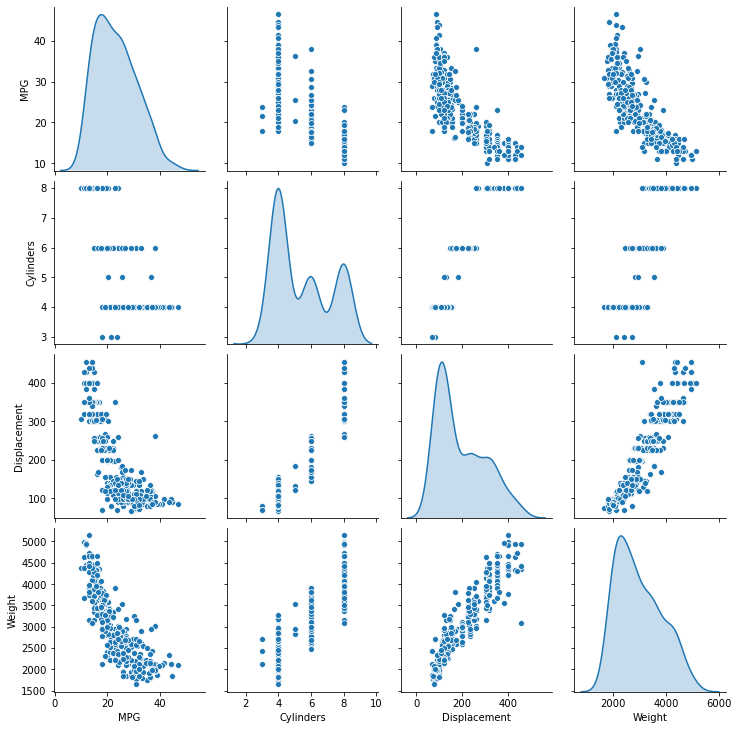

In [19]:
#Let's look at the data
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [20]:
#Let's split the features (x) from the labels (y)
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [21]:
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[5.47770691e+00 1.95318497e+02 1.04869446e+02 2.99025171e+03
 1.55592356e+01 7.58980942e+01 1.78343967e-01 1.97452217e-01
 6.24203861e-01]


In [22]:
## Let's do a linear model first!
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])
linear_model.predict(train_features[:10])

array([[ 0.1967467 ],
       [ 1.1148969 ],
       [-1.710184  ],
       [ 1.7320417 ],
       [ 3.2123623 ],
       [ 0.88971776],
       [ 3.4329543 ],
       [-0.23454553],
       [ 0.07656717],
       [ 1.8473523 ]], dtype=float32)

In [23]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


In [24]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Wall time: 1.76 s


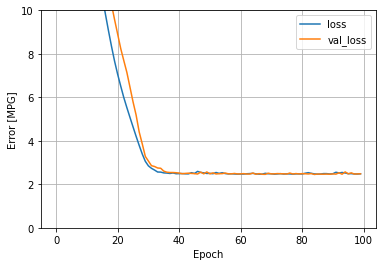

In [25]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
plot_loss(history)

In [26]:
test_results = {}
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [27]:
# Let's now try a DNN
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 9)                 19        
_________________________________________________________________
dense_2 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [28]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 1.9 s


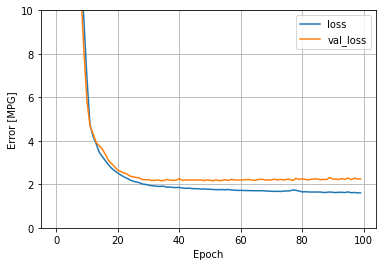

In [29]:
plot_loss(history)

In [30]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)


In [31]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
linear_model,2.543394
dnn_model,1.625501


### Let's do a classification example!
 
 Let's classify images of clothing!

In [32]:
#Import the dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [33]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
train_images.shape

(60000, 28, 28)

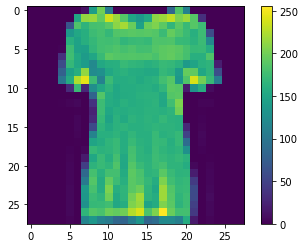

In [34]:
#Let's plot a random image
plt.figure()
plt.imshow(train_images[10])
plt.colorbar()
plt.grid(False)
plt.show()


In [35]:
# Let's normalize our data
train_images = train_images / 255.0

test_images = test_images / 255.0

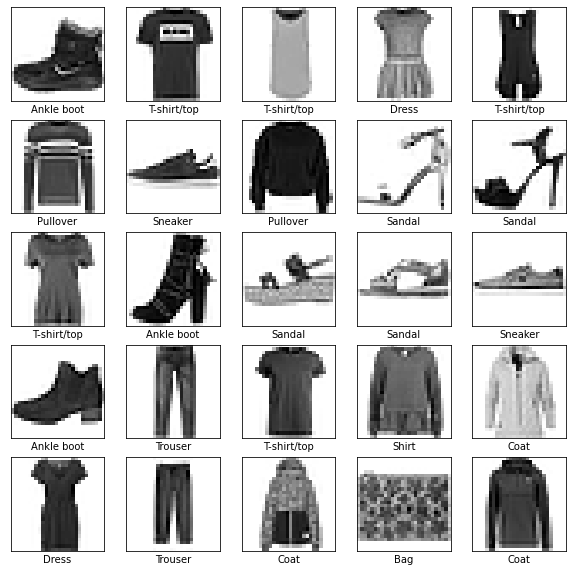

In [36]:
#Let's look at the data
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [37]:
#Now let's build the model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])


In [38]:
#Comple the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [39]:
#train
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 1s 647us/step - loss: 0.5006 - accuracy: 0.8240
Epoch 2/10
1875/1875 [==============================] - 1s 653us/step - loss: 0.3767 - accuracy: 0.8649
Epoch 3/10
1875/1875 [==============================] - 1s 697us/step - loss: 0.3367 - accuracy: 0.8775
Epoch 4/10
1875/1875 [==============================] - 1s 688us/step - loss: 0.3138 - accuracy: 0.8856
Epoch 5/10
1875/1875 [==============================] - 1s 774us/step - loss: 0.2956 - accuracy: 0.8909
Epoch 6/10
1875/1875 [==============================] - 2s 890us/step - loss: 0.2815 - accuracy: 0.8965
Epoch 7/10
1875/1875 [==============================] - 1s 631us/step - loss: 0.2673 - accuracy: 0.9001
Epoch 8/10
1875/1875 [==============================] - 1s 647us/step - loss: 0.2557 - accuracy: 0.9047
Epoch 9/10
1875/1875 [==============================] - 1s 653us/step - loss: 0.2467 - accuracy: 0.9087
Epoch 10/10
1875/1875 [==============================] - 1s 633u

In [40]:
#Let's test its accuracy!
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)


313/313 - 0s - loss: 0.3450 - accuracy: 0.8791

Test accuracy: 0.8791000247001648


In [41]:
#make predictions
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])


In [42]:
predictions = probability_model.predict(test_images)

In [43]:
predictions[0]

array([1.16222738e-08, 2.68366804e-14, 2.98178982e-10, 2.65633615e-14,
       1.78706321e-11, 7.14864698e-04, 1.12880365e-07, 1.11286610e-03,
       1.07301709e-07, 9.98172045e-01], dtype=float32)

In [44]:
np.argmax(predictions[0])

9

In [45]:
test_labels[0]

9

In [46]:
#ax functions
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


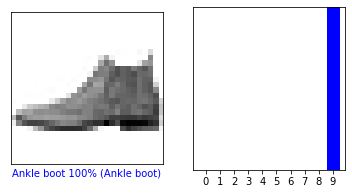

In [47]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

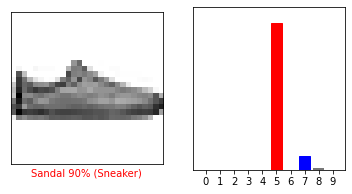

In [48]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

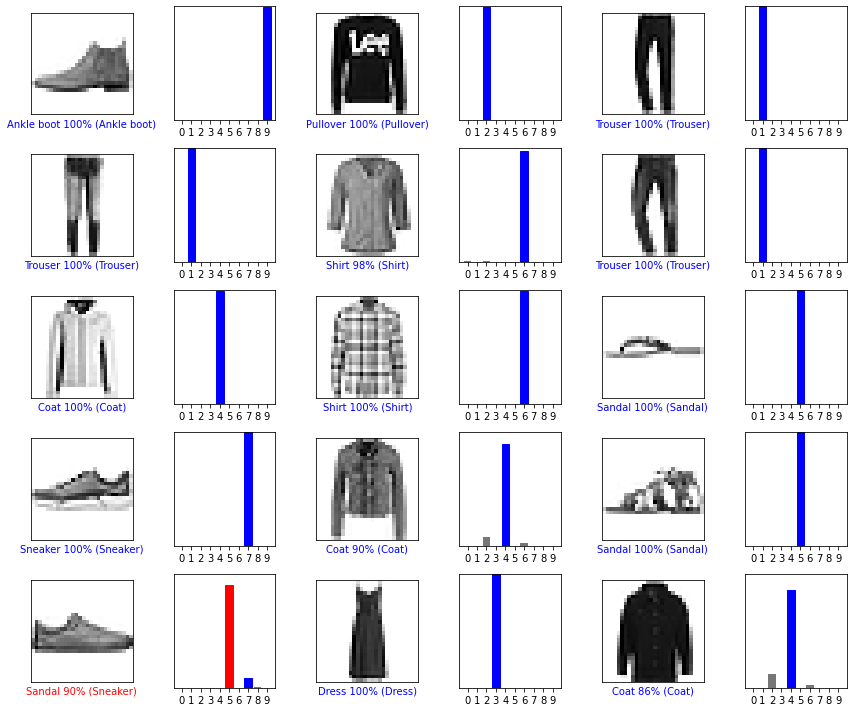

In [49]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## Now let's navigate some of the options that we used!

### Layers
We used Dense above, which is just your regular densely-connected NN layer.

    ''' 
    tf.keras.layers.Dense(
    units, activation=None, use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros', kernel_regularizer=None,
    bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
    bias_constraint=None, **kwargs
    )
    '''


In [66]:
# Create a `Sequential` model and add a Dense layer as the first layer.
modell = tf.keras.models.Sequential()
modell.add(tf.keras.Input(shape=(16,)))
modell.add(tf.keras.layers.Dense(32, activation='relu'))
# Now the model will take as input arrays of shape (None, 16)
# and output arrays of shape (None, 32).
# Note that after the first layer, you don't need to specify
# the size of the input anymore:
modell.add(tf.keras.layers.Dense(32))
modell.output_shape


(None, 32)

In [69]:
modell.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
Total params: 1,600
Trainable params: 1,600
Non-trainable params: 0
_________________________________________________________________


More than 30 types of layers in tensorflow, check them here! https://www.tensorflow.org/api_docs/python/tf/keras/layers

### activation functions

In [50]:
#Relu
foo = tf.constant([-10, -5, 0.0, 5, 10], dtype = tf.float32)
m=tf.keras.activations.relu(foo,alpha=0.0, max_value=None, threshold=0).numpy()
print(m)

[ 0.  0.  0.  5. 10.]


In [51]:
#elu
# x if x > 0 and alpha * (exp(x) - 1) if x < 0
foo = tf.constant([-10, -5, 0.0, 5, 10], dtype = tf.float32)
m=tf.keras.activations.elu(foo,alpha=500).numpy()
print(m)

[-499.9773 -496.631     0.        5.       10.    ]


In [52]:
#tanh
# tanh(x) = sinh(x)/cosh(x) = ((exp(x) - exp(-x))/(exp(x) + exp(-x))).
foo = tf.constant([-10, -5, 0.0, 5, 10], dtype = tf.float32)
m=tf.keras.activations.tanh(foo).numpy()
print(m)

[-1.         -0.99990916  0.          0.99990916  1.        ]


In [53]:
#Sigmoid
# sigmoid(x) = 1 / (1 + exp(-x))
foo = tf.constant([-10, -5, 0.0, 5, 10], dtype = tf.float32)
m=tf.keras.activations.sigmoid(foo).numpy()
print(m)

[4.5399931e-05 6.6928566e-03 5.0000000e-01 9.9330711e-01 9.9995458e-01]


For more on activation functions: https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid

### Optimizers 
Let's now go over some 

In [90]:
#Keras basic optimizer
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#train
model.fit(train_images, train_labels, epochs=2)

Epoch 1/2
1875/1875 [==============================] - 1s 631us/step - loss: 1.0708 - accuracy: 0.7915
Epoch 2/2
1875/1875 [==============================] - 1s 609us/step - loss: 0.5507 - accuracy: 0.8365


In [55]:
#RMSprop
model.compile(optimizer='RMSprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#train
model.fit(train_images, train_labels, epochs=2)

Epoch 1/2
1875/1875 [==============================] - 2s 766us/step - loss: 0.2181 - accuracy: 0.9192
Epoch 2/2
1875/1875 [==============================] - 2s 820us/step - loss: 0.2172 - accuracy: 0.9197


In [58]:
#Adam
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#train
model.fit(train_images, train_labels, epochs=2)

Epoch 1/2
1875/1875 [==============================] - 1s 622us/step - loss: 0.2116 - accuracy: 0.9215
Epoch 2/2
1875/1875 [==============================] - 1s 614us/step - loss: 0.2027 - accuracy: 0.9238


#### Learning rate scheduler

In [95]:
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1,
    decay_rate=0.9,
    staircase=True)

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=3)


Epoch 1/3
1875/1875 [==============================] - 1s 594us/step - loss: 0.7038 - accuracy: 0.8269
Epoch 2/3
1875/1875 [==============================] - 1s 618us/step - loss: 0.6595 - accuracy: 0.8288
Epoch 3/3
1875/1875 [==============================] - 1s 620us/step - loss: 0.6595 - accuracy: 0.8288


For more on optimizers: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers

### Loss functions 
Loss functions for regression are different from that for classification

These functions greatly impact the model. Some are harder to optimiz but has a physical meaning to the problem!

Some functions on tensorflow:
class BinaryCrossentropy: Computes the cross-entropy loss between true labels and predicted labels.

<code> class CategoricalCrossentropy </code>: Computes the crossentropy loss between the labels and predictions.

<code>class CategoricalHinge</code>: Computes the categorical hinge loss between y_true and y_pred.

<code>class CosineSimilarity</code>: Computes the cosine similarity between labels and predictions.

<code>class Hinge</code>: Computes the hinge loss between y_true and y_pred.

<code>class KLDivergence</code>: Computes Kullback-Leibler divergence loss between y_true and y_pred.


<code>class MeanAbsoluteError</code>: Computes the mean of absolute difference between labels and predictions.

<code>class MeanAbsolutePercentageError</code>: Computes the mean absolute percentage error between y_true and y_pred.

<code>class MeanSquaredError</code>: Computes the mean of squares of errors between labels and predictions.

<code>class MeanSquaredLogarithmicError</code>: Computes the mean squared logarithmic error between y_true and y_pred.


<code>class SparseCategoricalCrossentropy</code>: Computes the crossentropy loss between the labels and predictions.

<code>class SquaredHinge</code>: Computes the squared hinge loss between y_true and y_pred.

In [61]:
#SparseCategoricalCrossentropy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
#train
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 1s 637us/step - loss: 2.2645 - accuracy: 0.5165
Epoch 2/3
1875/1875 [==============================] - 1s 634us/step - loss: 2.2958 - accuracy: 0.6447
Epoch 3/3
1875/1875 [==============================] - 1s 634us/step - loss: 2.2949 - accuracy: 0.6458


In [62]:
#SparseCategoricalCrossentropy
model.compile(optimizer='adam',
              loss=tf.keras.losses.Hinge(),
              metrics=['accuracy'])
#train
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 2s 625us/step - loss: 1.9375 - accuracy: 0.2164
Epoch 2/3
1875/1875 [==============================] - 1s 626us/step - loss: 0.1007 - accuracy: 0.1544
Epoch 3/3
1875/1875 [==============================] - 1s 624us/step - loss: 0.1001 - accuracy: 0.1430


In [63]:
#BinaryCrossentropy (not applicable)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
#train
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 1s 619us/step - loss: -53.3765 - accuracy: 0.1035
Epoch 2/3
1875/1875 [==============================] - 1s 664us/step - loss: -53.4197 - accuracy: 0.0935
Epoch 3/3
1875/1875 [==============================] - 1s 642us/step - loss: -53.5024 - accuracy: 0.0865


For more on loss functions: https://www.tensorflow.org/api_docs/python/tf/keras/losses

### Metrics 
Metrics do not impact the performance of the model or the optimization process. They are there to help you evaluate the performance of the model, but they are different from regression to calssification. 

https://www.tensorflow.org/api_docs/python/tf/keras/metrics

for example 
<code> class CategoricalHinge </code>: Computes the categorical hinge metric between y_true and y_pred.

In [78]:
#Hinge(not applicable)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['CategoricalHinge'])
#train
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 2s 638us/step - loss: 2.3027 - categorical_hinge: 3265.3733
Epoch 2/3
1875/1875 [==============================] - 1s 635us/step - loss: 2.3027 - categorical_hinge: 3265.3696
Epoch 3/3
1875/1875 [==============================] - 1s 650us/step - loss: 2.3027 - categorical_hinge: 3265.3687


In [79]:
#(not useful)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['MeanSquaredError'])
#train
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 2s 659us/step - loss: 2.3027 - mean_squared_error: 6516.9326
Epoch 2/3
1875/1875 [==============================] - 1s 633us/step - loss: 2.3027 - mean_squared_error: 6516.9233
Epoch 3/3
1875/1875 [==============================] - 1s 635us/step - loss: 2.3027 - mean_squared_error: 6516.9282


In [80]:
#(not applicable)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['Precision'])
#train
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3


ValueError: in user code:

    C:\Users\asa279\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\Users\asa279\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\asa279\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\asa279\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\asa279\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\asa279\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    C:\Users\asa279\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:800 train_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    C:\Users\asa279\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:460 update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    C:\Users\asa279\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\utils\metrics_utils.py:86 decorated
        update_op = update_state_fn(*args, **kwargs)
    C:\Users\asa279\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\metrics.py:177 update_state_fn
        return ag_update_state(*args, **kwargs)
    C:\Users\asa279\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\metrics.py:1337 update_state  **
        sample_weight=sample_weight)
    C:\Users\asa279\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\utils\metrics_utils.py:366 update_confusion_matrix_variables
        y_pred.shape.assert_is_compatible_with(y_true.shape)
    C:\Users\asa279\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (32, 10) and (32, 1) are incompatible


Refernces:
    - François Chollet
    - Tensorflow.org
